## 라이브러리 불러오기

In [12]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

- 라이브러리를 불러옵니다.


## 경로 맞추고 리스트 만들기

In [13]:
# base_path에 전처리 된 데이터가 있는 폴더의 경로를 넣어줍니다.
# 전처리 된 파일이 있는 디렉토리를 넣어줍니다.
# 학우님 상황에 맞추어 넣어주시면 됩니다.
base_path = 'E:\celeba-dataset\processed'

# processed/x_train 폴더에 있는 npy를 sort하여 x_train_list에 넣어줍니다.
# processed/x_val 폴더에 있는 npy를 sort하여 x_val_list에 넣어줍니다.
x_train_list = sorted(glob.glob(os.path.join(base_path, 'x_train', '*.npy')))
x_val_list = sorted(glob.glob(os.path.join(base_path, 'x_val', '*.npy')))

# 두 list의 개수를 구합니다.
print(len(x_train_list), len(x_val_list))
# x_train_list[0]을 출력하여 경로를 확인합니다.
print(x_train_list[0])


162770 19867
E:\celeba-dataset\processed\x_train\000001.npy


(44, 44, 3) (44, 44, 3)


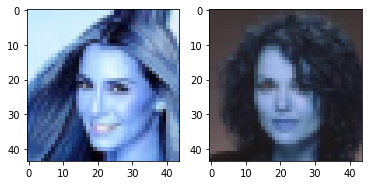

In [14]:
#  x_train_list와 x_val_list의 첫번째 파일을 불러옵니다.
x1 = np.load(x_train_list[0])
x2 = np.load(x_val_list[0])

# 두 변수의 shape을 출력합니다.
print(x1.shape, x2.shape)

# 두 파일을 matplotlib을 이용하여 시각화합니다.
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)

이미지 줄이기 전 사이즈 : (176,176,3) <br/>
이미지 줄인   후 사이즈 : (44, 44, 3) 

위 사진은 이미지 해상도를 1/4로 줄인 저해상도 이미지

## 데이터를 batch단위로 가져오기

In [4]:
"""
x_train_list를 batch단위로 데이터를 가져오는 generator를 생성합니다.
batch_size는 16이며 차원은 위에서 보았듯이 (44,44)이고 shuffle를 True로 하여 섞어줍니다. (176 -> 44)
"""
train_gen = DataGenerator(list_IDs=x_train_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=True)


"""
x_val_list를 batch단위로 데이터를 가져오는 generator를 생성합니다. <br/>
나머지는 위와 같고 validation할 때는 shuffle하지 않으므로 false를 넣어줍니다. (176->44)
"""
val_gen = DataGenerator(list_IDs=x_val_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=False)

## ESPCN 모델 생성

![ESPCN Model 구조](./ESPCN.png)

1. 저해상도 입력 이미지 
2. 여러 Convolutional layer를 거치기 (hidden layers)
3. 마지막에 Sub-pixel convolutional layer를 거쳐 고해상도로 변환하기
<br/>


* Sub-pixel convolutional layer : 
모든 픽셀을 포함 할 수 있는 크기 공간을 만들어 한 픽셀씩 규칙적으로 넣어주기
<br/><br/>


일반적인 저해상도 이미지를 고해상도로 만드는 기법(SR)은 저해상도를 고해상도로 먼저 바꾸고 여러 Convolutional layer를 거친다.<br/> 이 때문에 모델 파라미터 수가 많다.<br/><br/>
ESPCN은 저해상도 이미지를 바로 여러 Convolutional layer로 거쳐 마지막에 Sub-pixel convolutional layer로 해상도를 높여준다.<br/>
따라서 weight 파라미터 수가 줄고 모델이 경량화 되어 빠르게 모델을 학습할 수 있는 효과가 있다.<br/>

In [5]:
upscale_factor = 4

# input layer
inputs = Input(shape=(44, 44, 3))
print("input shape :" ,inputs.shape)

# hidden layer
net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)

# subpixel-layer
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)

# output layer
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

input shape : (?, 44, 44, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel_1 (Subpixel)        (None, 176, 176, 3)       6960      
_______________

## 모델 학습하기

In [ ]:
history = model.fit_generator(train_gen, validation_data=val_gen, epochs=10,  verbose=1, callbacks=[
    ModelCheckpoint('/models/model.h5', monitor='val_loss', verbose=1, save_best_only=True)
])

## 학습 된 모델 불러오기

In [6]:
from keras.models import load_model


model.load_weights('./models/model.h5')
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel_1 (Subpixel)        (None, 176, 176, 3)       6960      
_________________________________________________________________
activation_1 (Activation)    (None, 176, 176, 3)       0   

## 학습한 모델 테스트하기

In [7]:
x_test_list = sorted(glob.glob(os.path.join(base_path, 'x_test', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(base_path, 'y_test', '*.npy')))

print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

19962 19962
E:\celeba-dataset\processed\x_test\182638.npy


x1_test shape :  (44, 44, 3)
x1_test_resized shape :  (176, 176, 3)
y1_test shape :  (176, 176, 3)
y_pred :  (1, 176, 176, 3)


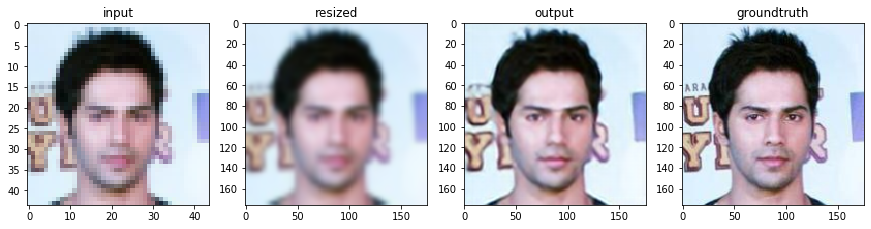

In [10]:
# test set 인덱스 5번째 이미지 사용
test_idx = 5

"""
x1_test         : 저해상도 이미지(input)
x1_test_resized : 확대시킨 이미지
y_pred          : 모델이 예측한 이미지(output)
y1_test         : 정답 이미지(ground_truth)
"""

# 데이터 전처리한 이미지 불러오기(input_ (44,44,3))
x1_test = np.load(x_test_list[test_idx])

# 딥러닝 모델을 거치지 않고 강제로 4배 확대하기
x1_test_resized = pyramid_expand(x1_test, 4, multichannel=True)

# 딥러닝 모델로 4배 확대시킨 고해상도 이미지 예측하기 
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

# 정답 이미지 불러오기(176,176,3)
y1_test = np.load(y_test_list[test_idx])

print("x1_test shape : ", x1_test.shape)
print("x1_test_resized shape : ", x1_test_resized.shape)
print("y1_test shape : ", y1_test.shape)
print("y_pred : ", y_pred.shape)

# 이미지 출력할 수 있도록 opencv로 처리하기
x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

# 이미지 출력
plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)

plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)

plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)

plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)

* 첫번째 이미지 : 4배로 줄인 입력 이미지<br/> 
눈,코,입 모두 알아보기 힘듦<br/>
<br/>

* 두번째 이미지 : 강제로 4배 늘린 이미지<br/>
이미지가 흐릿함<br/>
<br/>

* 세번째 이미지 : 딥러닝 모델로 4배 늘린 이미지<br/>
입력 이미지와 비교했을 때 매우 선명하고 눈, 코, 입 모두 알아볼 수 있음<br/>
옆 정답 이미지와 비교했을 때 매우 비슷한 것을 확인 할 수 있음<br/>
<br/>

* 네번째 이미지 : 정답이미지<br/>
